## sis_tuning.py用可視化ツールの template です。
- 概要：
  - 全 cell を実行すると、XFFTsのボードに対応付けたSIS素子 の チューニング plot が表示されます
    - 100 GHz 帯 ( SSB ) 素子 : 8 個

- 230 GHz帯域のIFはLOが自動制御になっていないのでチューニングパラメータを探せません。

In [1]:
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d
import matplotlib
matplotlib.rcParams['font.size'] = 12
import matplotlib.pyplot as plt
import necstdb
from scipy.interpolate import griddata

In [2]:
cwd = "./necst_sis_tuning_20240816_204421"
db = necstdb.opendb(cwd)
filename = cwd.split("/")[-1].split(".")[0]

In [3]:
def conv_xarray(db, topic, field, name=''):
    array_data = db.open_table(topic).read(astype="array")
    xarray_data = xr.DataArray(array_data[field], dims=['time'], coords={'time' : array_data['time']}, name=name)
    return xarray_data

def conv_xarray_cmd(db, topic, field, name=''):
    array_data = db.open_table(topic).read(astype="array")
    xarray_data = xr.DataArray(array_data[field], dims=['time'], coords={'time' : array_data['recorded_time']}, name=name)
    return xarray_data

def xffts_conv_xarray(db, topic, range, name=''):
    array_data = db.open_table(topic).read(astype="array")
    sum = [data[range[0]:range[1]].sum() for data in array_data["data"]]
    xarray_data = xr.DataArray(sum, dims=['time'], coords={'time' : array_data['time']}, name=name)
    return xarray_data

def resample_pre(resample_xarray, reference_xarray, index="time", kind="previous", **kwargs):
    resample_func = interp1d(resample_xarray[index].values, resample_xarray.values, kind, **kwargs)
    return resample_func(reference_xarray[index].values)

In [4]:
xffts_topics = {
        'board1': '2LL',
        'board2': '2RU',
        'board3': '2RL',
        'board4': '3LU',
        'board5': '3LL', 
        'board6': '3RU',
        'board7': '3RL',
        'board8': '4LU',
        'board9': '4LL',
        #'board10': '1LU', 
        'board11': '2LU',
        'board12': '5LU',
        'board13': '5LL', 
        'board14': '5RU', 
        'board15': '5RL',
        #'board16': '5RL',
}

beam_list = [
    '2L', '2R', '3L', '3R',
    '4L', '4R', '5L', '5R', 
]

sis_topic_list = [f"necst-NANTEN2-rx-sis_bias-sis_{beam}" for beam in beam_list]

In [5]:
power_xffts = {}
for board, if_name in xffts_topics.items():
    power_xffts[if_name] = xffts_conv_xarray(db, "necst-NANTEN2-data-spectral-"+board, [2000,32767])

In [6]:
chopper = conv_xarray(db, "necst-NANTEN2-ctrl-calib-chopper_status", "insert")
vol_df = {}
vol_cmd_df = {}
loatt_df = {}
cur_df = {}
for sis_topic, beam in zip(sis_topic_list, beam_list):
    vol_df[beam] = conv_xarray(db, sis_topic, "voltage")
    vol_cmd_df[beam] = conv_xarray_cmd(db, "necst-NANTEN2-rx-sis_bias_cmd", "voltage")
    cur_df[beam] = conv_xarray(db, sis_topic, "current")
    loatt_df[beam] = conv_xarray(db, "necst-NANTEN2-rx-local_attenuator_cmd", "current")

In [7]:
sum_data = {}
for beam in beam_list:
    beam_if = [s for s in list(xffts_topics.values()) if s.startswith(beam)]
    for if_name in beam_if:
        sum_data[if_name] = xr.DataArray(
            power_xffts[if_name].values, 
            coords={
                'time' : power_xffts[if_name]['time'].values, 
                'sisvol' : ('time', resample_pre(vol_df[beam], power_xffts[if_name], kind='linear', fill_value="extrapolate")), 
                'sisvol_cmd' : ('time', resample_pre(vol_cmd_df[beam], power_xffts[if_name], fill_value="extrapolate")), 
                'chopper' : ('time', resample_pre(chopper, power_xffts[if_name], fill_value="extrapolate")),  
                'siscur' : ('time', resample_pre(cur_df[beam], power_xffts[if_name], kind = 'linear', fill_value="extrapolate")), 
                'loatt' : ('time', resample_pre(loatt_df[beam], power_xffts[if_name], fill_value="extrapolate"))}, 
                dims='time')

In [8]:
pd_sum_data = {}
for key in sum_data.keys():
    pd_sum_data[key] = sum_data[key].to_dataframe("power")

In [9]:
pd_sum_mean = {}
for key in pd_sum_data.keys():
    pd_sum_mean[key] = pd_sum_data[key].groupby(['loatt', 'sisvol_cmd', 'chopper']).median()

In [10]:
def yfactor(x):
    return 10*np.log10(x/x.shift(1))

def tsys(y):
    y_ = 10**(y/10)
    tsys = (290)/(y_-1)
    return tsys

In [11]:
for key in pd_sum_mean.keys():
    pd_sum_mean[key]['yfactor'] = pd_sum_mean[key].groupby(['loatt','sisvol_cmd'])['power'].apply(yfactor)
    pd_sum_mean[key]['Tsys'] = pd_sum_mean[key].groupby(['loatt','sisvol_cmd'])['yfactor'].apply(tsys)

/var/folders/yy/32l8vphx21x8z5znjt6jsk480000gn/T/ipykernel_25043/1716652839.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pd_sum_mean[key]['yfactor'] = pd_sum_mean[key].groupby(['loatt','sisvol_cmd'])['power'].apply(yfactor)
/var/folders/yy/32l8vphx21x8z5znjt6jsk480000gn/T/ipykernel_25043/1716652839.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil

In [12]:
pd_sum_power = {}
for key in pd_sum_mean.keys():
    pd_sum_power[key] = pd_sum_mean[key][pd_sum_mean[key]['yfactor'].notna()].reset_index()
    pd_sum_power[key]['Tsys'] = pd_sum_power[key].groupby(['loatt','sisvol_cmd'])['yfactor'].apply(tsys)

/var/folders/yy/32l8vphx21x8z5znjt6jsk480000gn/T/ipykernel_25043/4292995438.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pd_sum_power[key]['Tsys'] = pd_sum_power[key].groupby(['loatt','sisvol_cmd'])['yfactor'].apply(tsys)
/var/folders/yy/32l8vphx21x8z5znjt6jsk480000gn/T/ipykernel_25043/4292995438.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silen

In [13]:
pd_sum_power["2LU"].sort_values("yfactor")[10:]

,loatt,sisvol_cmd,chopper,sisvol,siscur,power,yfactor,Tsys
8,3.0,7.0,1.0,7.081051,39.888904,2.360636e+17,2.600466,353.703391
12,3.5,7.0,1.0,7.081057,26.860761,2.305226e+17,2.625123,349.289097
2,2.0,8.0,1.0,8.105355,129.560729,2.822712e+17,2.741092,329.624288
6,2.5,8.0,1.0,8.103502,102.537496,3.705650e+17,2.984400,293.490138
17,4.0,7.5,1.0,7.593303,30.013023,3.492196e+17,3.195131,266.800340
0,2.0,7.0,1.0,7.553460,111.964382,3.727578e+17,3.203531,265.812330
1,2.0,7.5,1.0,7.737108,118.211641,3.764738e+17,3.248448,260.619377
13,3.5,7.5,1.0,7.592552,41.994393,4.068421e+17,3.371833,247.099012
9,3.0,7.5,1.0,7.592771,58.720490,4.733098e+17,3.530067,231.209415
5,2.5,7.5,1.0,7.576546,82.268816,5.062571e+17,3.580996,226.409490


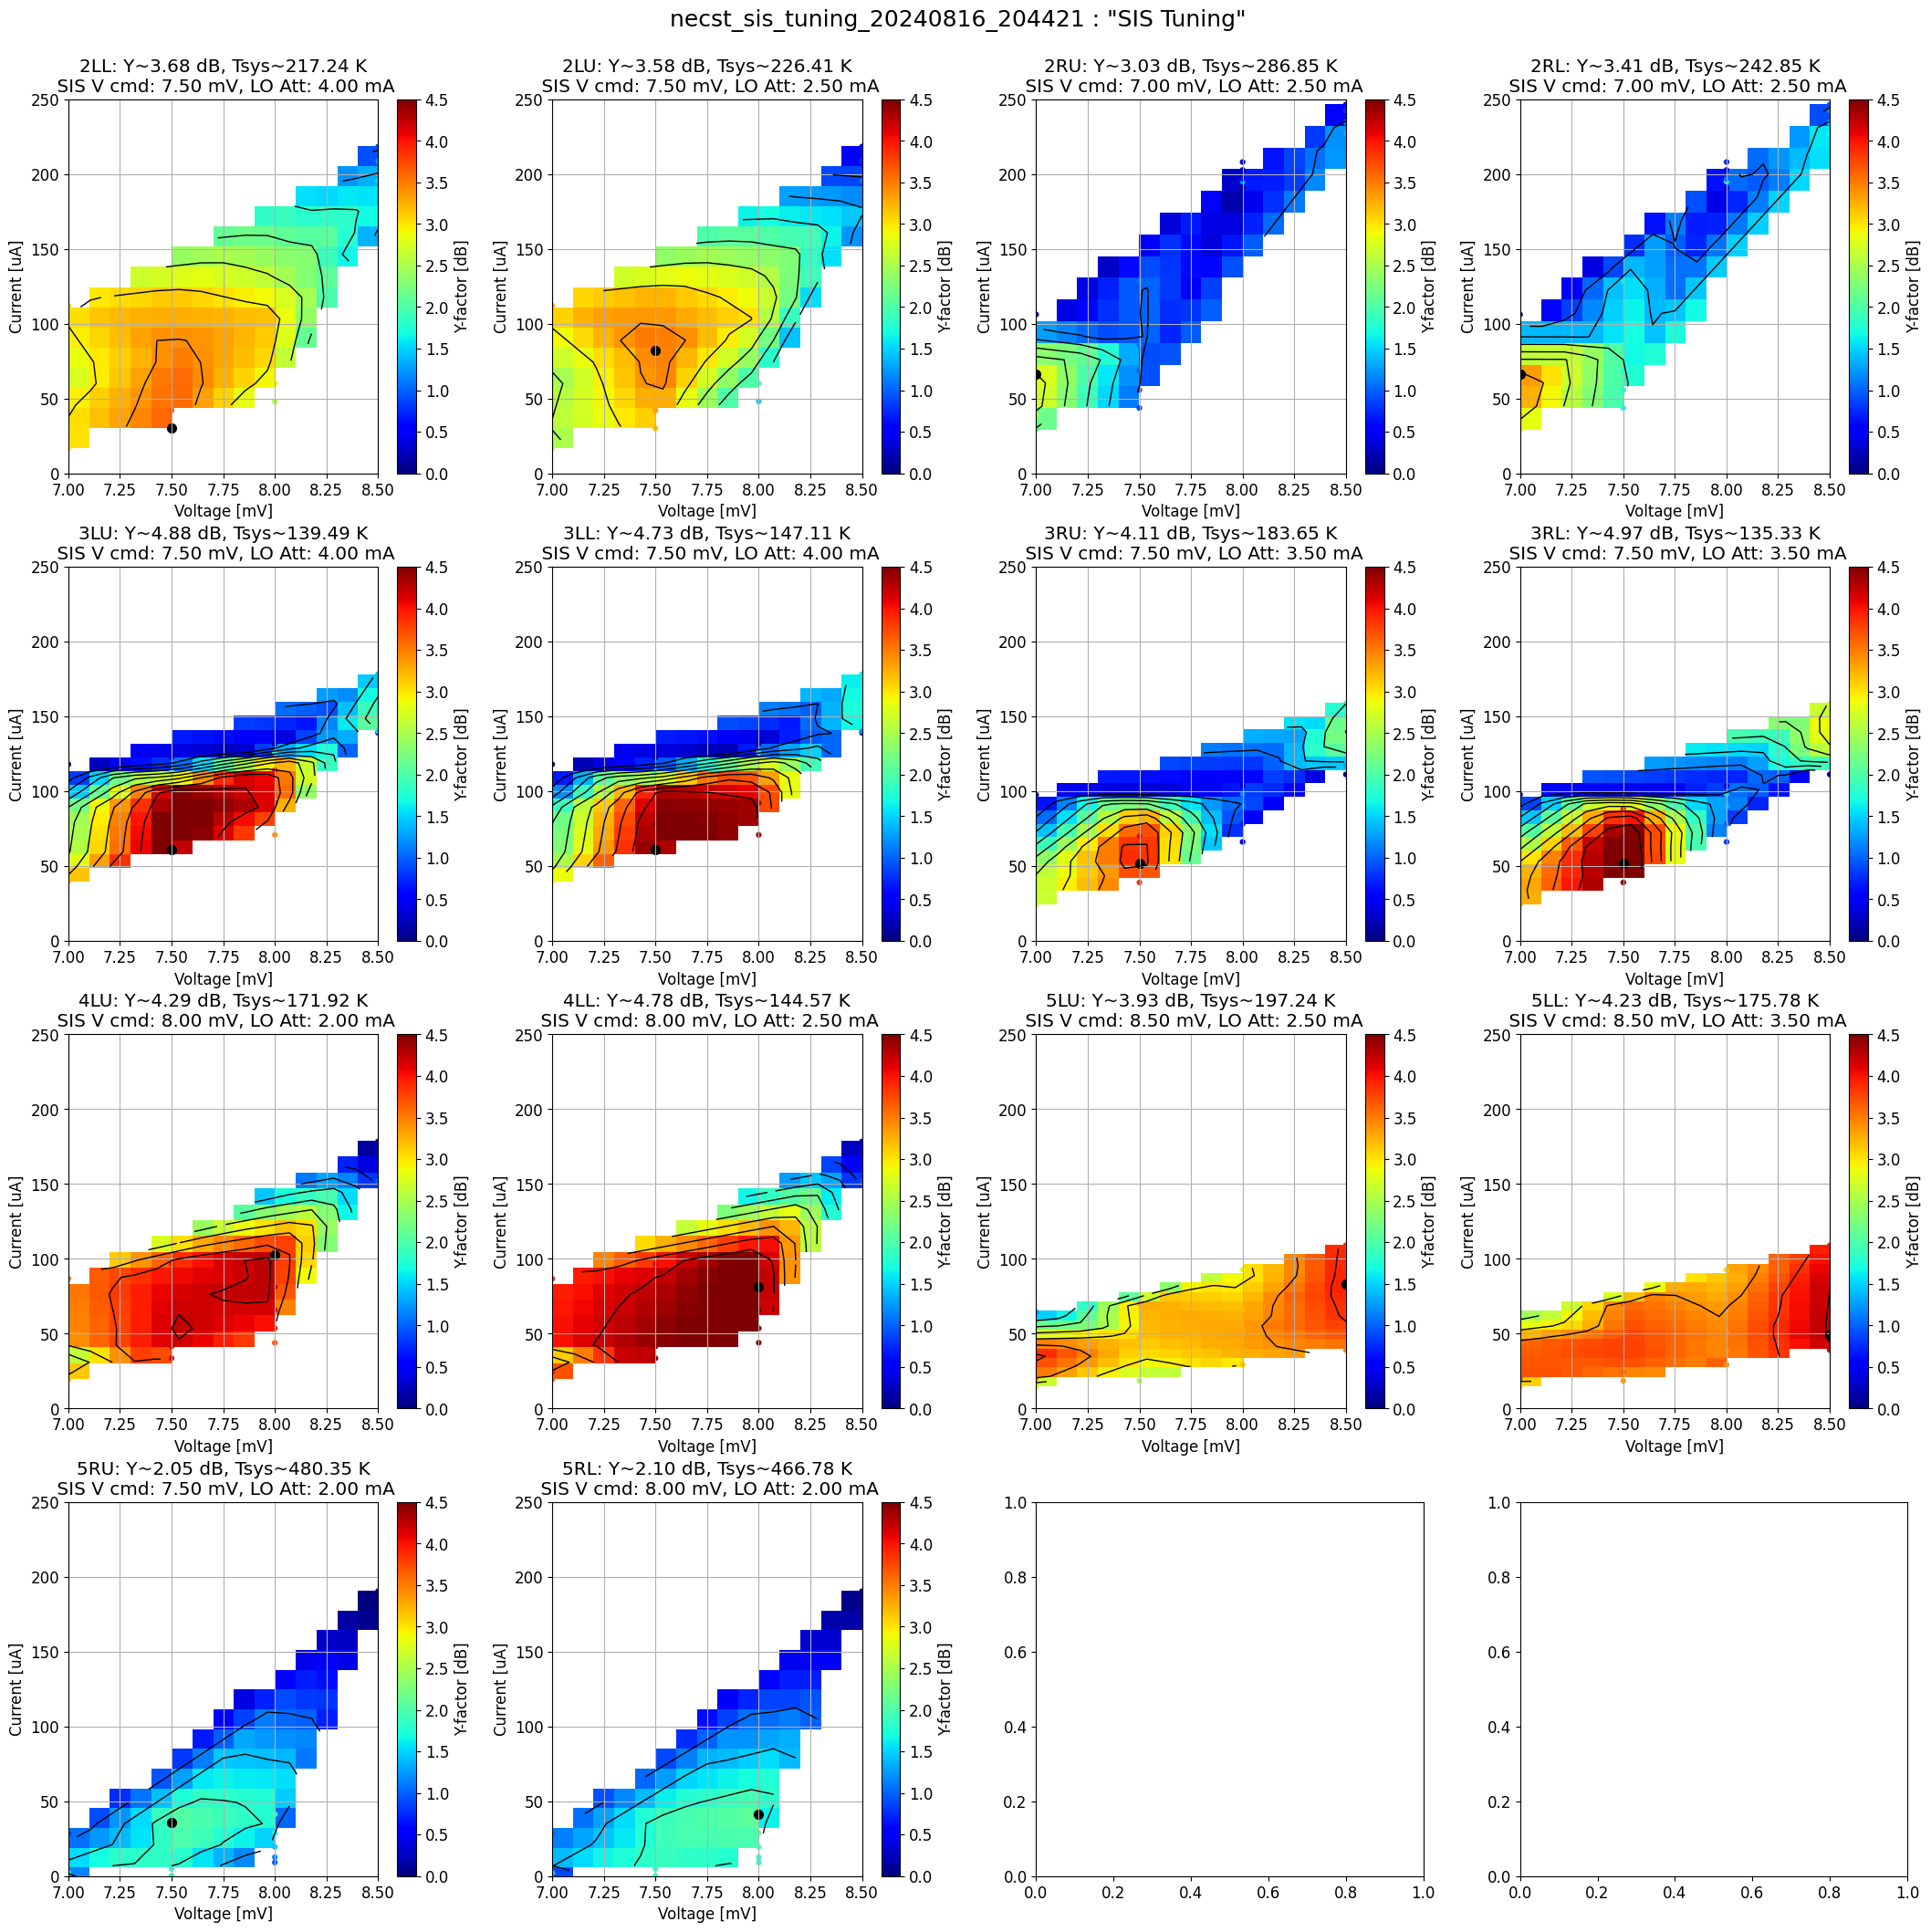

In [18]:
ncol = 4
nrow = 4
nax = ncol * nrow

figsize = (ncol * 6.5, nrow * 5.5)

fig = plt.figure(figsize=figsize)
ax = [fig.add_subplot(4, 4, i+1) for i in range(16)]
for key, _ax in zip(pd_sum_power.keys(), ax):
    try:
        # データ範囲を取得
        x_min, x_max = pd_sum_power[key]['sisvol_cmd'].min(), pd_sum_power[key]['sisvol_cmd'].max()
        y_min, y_max = pd_sum_power[key]['siscur'].min(), pd_sum_power[key]['siscur'].max()
        z_max = pd_sum_power[key]['yfactor'].max()

        # 取得したデータ範囲で新しく座標にする配列を作成
        new_x_coord = np.linspace(x_min, x_max, 15)
        new_y_coord = np.linspace(y_min, y_max, 15)

        # x, yのグリッド配列作成
        xx, yy = np.meshgrid(new_x_coord, new_y_coord)
        # データの補間
        grid_z = griddata((pd_sum_power[key]['sisvol_cmd'], pd_sum_power[key]['siscur']), pd_sum_power[key]['yfactor'], (xx, yy), method='linear', rescale=True)

        # Plot
        im = _ax.imshow(grid_z, extent=(x_min, x_max, y_min, y_max), aspect="auto", origin='lower', cmap='jet', vmin = 0, vmax = 4.5)
        _ax.contour(grid_z, extent=(x_min, x_max, y_min, y_max), colors="k", levels=np.arange(1, 4.5, 0.4), linewidths=1)
        mappable = _ax.scatter(pd_sum_power[key]['sisvol_cmd'], pd_sum_power[key]['siscur'], c=pd_sum_power[key]['yfactor'], vmin = 0, vmax = 4.5, cmap='jet', s=12)
        _ax.set_xlabel('Voltage [mV]')
        _ax.set_ylabel('Current [uA]')
        bar = fig.colorbar(mappable)
        bar.set_label('Y-factor [dB]')
        _ax.grid()
        max_index = pd_sum_power[key]['yfactor'].idxmax()
        max_yfac = pd_sum_power[key].loc[max_index, 'yfactor']
        max_tsys = pd_sum_power[key].loc[max_index, 'Tsys']
        max_x = pd_sum_power[key].loc[max_index, 'sisvol_cmd']
        max_y = pd_sum_power[key].loc[max_index, 'siscur']
        max_loatt = pd_sum_power[key].loc[max_index, 'loatt']
        _ax.scatter(max_x, max_y, c='black', s=50, label='Max Y-factor')
        _ax.set_title("{}: Y~{:.2f} dB, Tsys~{:.2f} K\n SIS V cmd: {:.2f} mV, LO Att: {:.2f} mA".format(key, max_yfac, max_tsys, max_x, max_loatt))
        _ax.set_ylim(0, 250)
    except Exception as e:
        continue
plt.suptitle((f'{filename} : "SIS Tuning"'), fontsize=18)
plt.subplots_adjust(wspace=0.25, hspace=0.25, bottom=0.05)
plt.subplots_adjust(top=0.935)
plt.savefig(f'sis_tuning_v4_{filename}.png')